## Lagrangian Hydrodynamics

<h3>INTRODUCTION</h3>
An inviscid fluid flow is described through the following conservation equations collectively known as the <b>Euler equations</b>.

Conservation of mass (continuity equation):
$$
\dot{\rho} + \nabla(\rho\,\mathbf{v}) = 0, \ \ \text{or} \ \ \ \ \left( \frac{\partial }{\partial t} + \mathbf{v} \nabla\right) \rho = - \rho \nabla\mathbf{v}
$$

Conservation of momentum: (Navier Stokes equation)
$$
\rho \left( \frac{\partial }{\partial t} + \mathbf{v} \cdot \nabla  \right) \mathbf{v}= -\nabla p + \rho \nu \nabla^2 \mathbf{v},
$$
where $\nu$ is the kinematic viscosity.

Conservation of energy: 
$$
\frac{\partial e}{\partial t} + \nabla\cdot(e\,\mathbf{v}) + p\nabla\cdot\mathbf{v} = 0
$$

In certain situations the pressure can sometimes be expressed as a function of $\rho$ only. Such as in the isothermal equation of state $p=c_0^2\,\rho$, where $c_0$ is the speed of sound. In this case the behavior is given only from the continuity equation and the momentum equation. Because $\nabla p=c_0^2 \nabla\rho$ and that is all we need for the momentum equation.

In this case for a Lagrangian description this boils down to solving this single equation:
$$
\frac{D\mathbf{v}}{Dt} = -\frac{1}{\rho}\nabla p
$$

So we have a second-order differential equation for the positions of our mass grid. 

So imagine we discretized the total mass $M$ with $N$ shells of mass, $\triangle m$ , with edges of $r_i$ with $0<i<N$ in the domain $[0,1]$. Call the initial pressure distribution at time zero $p_0$ and realize that the density, $\rho_i$ in our grid zones is always just simply given by $\rho_i = \triangle m/|r_{i+1}-r_{i}|$. So if we can describe our fluid purely with an equation of state described by $p = c_0^2\rho$ we only need to store the initial value of $c_0$ which may be a different in differenct parcels of the gas. 

We will first use a simple leap frog integrator to solve this. This operates in two parts. First we update the positions by half a time step $r_i = r_i + (dt/2)\,v_i$ then using these positions to calculate the accelerations 

\begin{equation}
-\frac{1}{\rho}\nabla p = - \frac{|r_{i+1}-r_i|}{\triangle m} 
 \nabla \left(\frac{\triangle m c_{0,i}^2}{|r_{i+1}-r_i|}\right)=-\frac{1}{\triangle m} \triangle r_i \nabla\frac{\triangle m c_{0,i}^2}{\triangle r_i},
\end{equation}
where $\triangle r_i = |r_{i+1}-r_i|$. Then we do the remaining part of the kick of the positions $r_i = r_i + (dt/2)\,v_i$. The two kicks can be combined one we keep them separate here so that at outputs we have positions and velocities at the same time. In the case where all shells have the same mass we could even eliminate $\triangle m$ in the accelerations. This may not in general be the case, however, so we keep it.
<p>
For the special case where pressure is only a function of density these are the only equations we would need. More gnerally we also have to consider an energy (or entropy) equation in order to account for the possibility that the internal energy could be different for different densities. However, in the Lagrangian case we know right away that the energy change is just the work done on the cell. I.e.
$$
\frac{Du}{dt} = - p \frac{dV}{dt},
$$ 
where $dV$ is the rate of change of the fluid element volume we are considering. 

<h3>Sound waves</h3>

Linearizing the continuity and momentum equation above for small perturbations $\rho_1$ and $v_1$ (i.e. assume $\rho = \rho_0 + \rho_1$ and $v = 0+v_1$) and differentiating the momentum equation one more time in time we can obtain the wave solutions with the linear dispersion relation $\omega=ck$
$$
v = v_{a} \exp[i(kx+\omega t)] = v_{a}\exp[ik(x + c t)] , \ \ \ \rho = \rho_0 \left(1-\frac{v_1}{c}\right).
$$
The mass coordinate is 
$$
m(x) = \int_0^1 \rho dx = \rho_0\left[x+\frac{v_a}{2\pi\,c_0}(\cos(2\pi\,x)-1)\right]
$$
so to set up a simple test we can choose equidistant points in mass and derive the positions by finding the roots of this last equation. 


Populating the interactive namespace from numpy and matplotlib
664  time steps to time:  0.600526954074


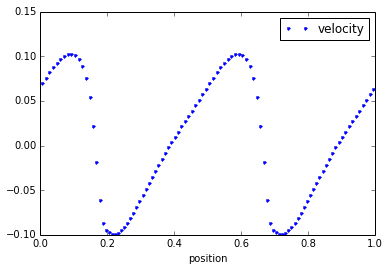

In [2]:
%pylab inline
import time as systime
#from scitools.std import as sci
from scipy.optimize import brentq 

def accGradP(dr,m,c):
    diff = c**2* (m/fabs(dr))
    return -1./m*dr*(diff-np.roll(diff,1))/(0.5*fabs(dr+np.roll(dr,1)))

N = 100
r = (0.+np.arange(N))/N
va = .1
rho0 = 1.
c = 1.
v = va*sin(4.*np.pi*r)
c0 = np.ones(N)
c0[:] = c
m = 1./N

mass = lambda x,off: rho0*(x+va/c*(cos(4.*np.pi*x)-1)/4/np.pi)-off
for i in range(len(r)):
    r[i] = brentq(mass,0,1,args=(r[i]))
dr = np.roll(r,-1)-r

    
Courantfactor = 0.1
dt = Courantfactor * 1./N

tfinal = 0.6
time = [0.]
vmax = [max(v)]
count=0
while (time[-1]<tfinal and count < 500000):
    r += dt/2 * v
    r[r>1] -= 1.
    r[r<0] += 1.
    dr = np.roll(r,-1)-r
    ind = where(fabs(dr)>0.5)
    dr[ind] = fabs(1.+dr[ind])
    acc = accGradP(dr,m,c0) 
    v += dt * acc
#    print accGradP(r,m,c0)
    r += dt/2 * v
    dt = Courantfactor*min(dr)/max((max(c0),max(v)))
    time.append((time[-1]+dt))
    count += 1
    vmax.append(max(v))
    
print count, ' time steps to time: ', time[-1]
plot(r,v,'.',label="velocity")
xlabel("position")
legend();

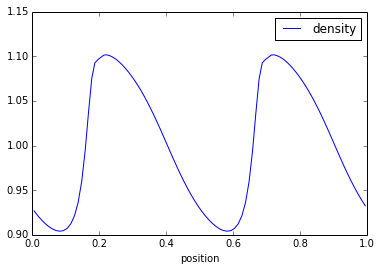

In [3]:
plot(r,m/dr,label="density");
xlabel('position')
legend();

<h4>Oh no!!!</h4>

Did we screw up our approach to solving the equations? 
What happened to our wave? 



## Wave steepening

Essentially all non-linear wave steepen! The ones that do not are arranged such that their dispersion just cancels the steepening. These are called <i>solitary wave</i> or <a href="http://en.wikipedia.org/wiki/Soliton" target="_blank"><i>solitons</i></a>. This is actually quite easy to understand. The sound speed of a gas is given by $c^2 = \partial p/\partial \rho$

<h3>Artificial Viscosity</h3>

<a href="http://jap.aip.org/resource/1/japiau/v21/i3/p232_s1">A Method for the Numerical Calculation of Hydrodynamic Shocks</a>
1950 by J. VonNeumann and R. D. Richtmyer layed out how to study shock waves by inroducing a so called artificial viscosity into the method. Let us explore this and see whether we can make it work. 

1326  time steps to time:  1.50089796648


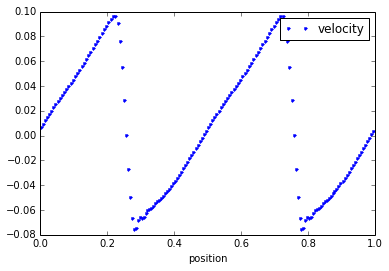

In [4]:
def accVisc(dr,m,v,dx_smear=.01):
    dv = (np.roll(v,-1)-v)/dr
    dif = -dx_smear**2 *dv*fabs(dv)  *(fabs(dr)/m)
    return -1./m*dr*(dif-np.roll(dif,1))/(0.5*fabs(dr+np.roll(dr,1)))

def accGradP(dr,m,c):
    dif = c**2* (m/fabs(dr))
    return -1./m*dr*(dif-np.roll(dif,1))/(0.5*fabs(dr+np.roll(dr,1)))

N = 160
r = (0.+np.arange(N))/N
xL = r+.5/N
va = .1
rho0 = 1.
c = 1.
v = va*sin(4.*np.pi*r)
c0 = np.ones(N)
c0[:] = c
m = 1./N

mass = lambda x,off: rho0*(x+va/c*(cos(4.*np.pi*x)-1)/4/np.pi)-off
for i in range(len(r)):
    r[i] = brentq(mass,0,1,args=(r[i]))
dr = np.roll(r,-1)-r

Courantfactor = 0.2
dt = Courantfactor * 1./N/max(v)

tfinal = 1.5
time = [0.]
vmax = [max(v)]
count=0
while (time[-1]<tfinal and count < 500000):
    r += dt/2 * v
    r[r>1] -= 1.
    r[r<0] += 1.
    dr = np.roll(r,-1)-r
    ind = where(fabs(dr)>0.5)
    dr[ind] = fabs(1.+dr[ind])
    acc = accGradP(dr,m,c0) + accVisc(dr,m,v,dx_smear=.02)
    v += dt * acc
#    print accGradP(r,m,c0)
    r += dt/2 * v
    dt = Courantfactor*min(dr)/max((max(c0),max(v)))

    time.append((time[-1]+dt))
    count += 1
    vmax.append(max(v))
    
print count, ' time steps to time: ', time[-1]
plot(r,v,'.',label="velocity")
xlabel("position")
legend();

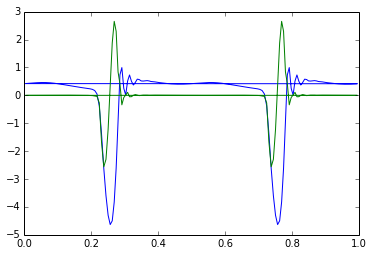

In [5]:
plot(r,accGradP(dr,m,c0), r, .01*accVisc(dr,m,v,dx_smear=.5));

Clean up the code a bit.

In [6]:
def diff(y):
    return y[1:]-y[0:-1]
def av(y):
    return (y[1:]+y[0:-1])/2
def eos_u(rho, p):
    u = p
    return u
    
class EquationOfState:
    def __init__(self, gammain):
        self.gamma = gammain
    def u(self,rho,p):
        return 1./(self.gamma-1.) * p/rho
    def cs(self,rho,p):
        return sqrt(self.gamma*p/rho)
    def p(self,rho,u):
        return (self.gamma-1)*rho*u

def VNR_q(dr,dm,v,kdx=.1):
    '''return VanNeumann Richtmyer viscosity'''
    dv = (v-np.roll(v,-1))/dr
    q = -kdx**2 *dv*fabs(dv)  *dr/dm
    return q

def accGradP(dr,m,p):
    rho = m/dr
    return -1./rho*(p-np.roll(p,1))/(0.5*fabs(dr+np.roll(dr,1)))

gasgamma = 1.001
eos = EquationOfState(gasgamma)

def LagrangeHydro(tfinal, r, v, dm, p):
    N = len(r)
    Courantfactor = 0.2
    dr = np.roll(r,-1)-r # cell volumes. 
    ind = where(fabs(dr)>0.5)
    dr[ind] = fabs(1.+dr[ind])
    drold = dr
    rho = dm/dr
    u = eos.u(rho, p)
    cs = eos.cs(rho,p)
    dt = Courantfactor * 1./N/max((max(cs), max(v)))
    kvnr = 4.
    dxvnr = 1./N

    count=0
    time = 0.
    while (time<tfinal and count < 500000):
        r += dt/2 * v
        dr = np.roll(r,-1)-r
        ind = where(fabs(dr)>0.5)
        dr[ind] = fabs(1.+dr[ind])
        q = VNR_q(dr,dm,v,kdx=kvnr*dxvnr)
        p = eos.p(dm/dr,u)
        
        acc = accGradP(dr,m,p+q) 
        v += dt * acc
    #    print accGradP(r,m,c0)
        r += dt/2 * v
        r[r>1] -= 1.
        r[r<0] += 1.

        dr = np.roll(r,-1)-r # cell volumes. 
        ind = where(fabs(dr)>0.5)
        dr[ind] = fabs(1.+dr[ind])
        
        dV = dr-drold
        u -= (p+q)*dV/dm
        rho = dm/dr
        p = eos.p(rho,u)
        
        drold = dr
        time += dt
        dt = Courantfactor*min(abs(dr))/(max(eos.cs(rho,p+q)+abs((v-np.roll(v,-1)) ))) # new time step

        count += 1
    return r, v, rho, p, u

In [7]:
N = 160
r = (0.+np.arange(N))/N
xL = r+.5/N
va = .1
rho0 = 1.
c = 1.
v = va*sin(4.*np.pi*r)
c0 = np.ones(N)
c0[:] = c
m = 1./N

mass = lambda x,off: rho0*(x+va/c*(cos(4.*np.pi*x)-1)/4/np.pi)-off
for i in range(len(r)):
    r[i] = brentq(mass,0,1,args=(r[i]))
dr = np.roll(r,-1)-r
ind = where(fabs(dr)>0.5)
dr[ind] = fabs(1.+dr[ind])

p = m/dr

r, v, den, p, u = LagrangeHydro(.1, r, v, m, p)

In [8]:
import JSAnimation
from JSAnimation import IPython_display
from matplotlib import animation

def HydroMovie(solver, h=1.0, tfinal=2*2.0*np.pi, w0=1.0, phase=1.0):
    x, v, t = solver(tfinal, h, w0, phase)
    
    skiprate = int(len(t) / 100)
    skiprate = max(skiprate, 1)
    t = t[::skiprate]
    x = x[::skiprate]
    v = v[::skiprate]
    # create a simple animation
    fig = plt.figure()

    ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2))
    line, = ax.plot([], [], lw=2)
    ax.set_xlabel('x')
    ax.set_ylabel('v')
        
    def init():
        line.set_data([], [])
        return line,
    
    def animate(i):
        line.set_data(x[:i], v[:i])
        return line,
    
    return animation.FuncAnimation(fig, animate, init_func=init,
                            frames=len(t), interval=60, blit=True)

In [9]:

mass = lambda x,off: rho0*(x+va/c*(cos(4.*np.pi*x)-1)/4/np.pi)-off
for i in range(len(r)):
    r[i] = brentq(mass,0,1,args=(r[i]))
dr = np.roll(r,-1)-r


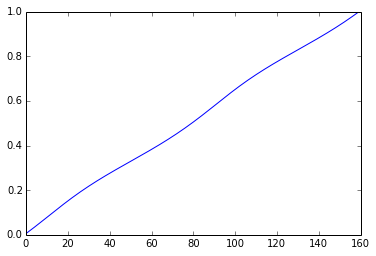

In [93]:
plot(r)

In [100]:
mf = range(10)
np.roll(r, -1)-r

array([ 0.00698341,  0.00706192,  0.0071363 ,  0.00720572,  0.00726939,
        0.00732676,  0.00737728,  0.00741957,  0.00745207,  0.00747435,
        0.0074859 ,  0.00748623,  0.00747528,  0.00745284,  0.00741937,
        0.00737537,  0.00732124,  0.00725829,  0.00718708,  0.00710909,
        0.00702527,  0.00693694,  0.0068452 ,  0.00675134,  0.00665609,
        0.00656097,  0.00646619,  0.00637302,  0.00628199,  0.00619343,
        0.006108  ,  0.0060261 ,  0.00594791,  0.00587364,  0.0058035 ,
        0.00573763,  0.00567612,  0.00561904,  0.00556641,  0.00551825,
        0.00547449,  0.00543507,  0.00540004,  0.00536937,  0.00534296,
        0.00532082,  0.00530305,  0.00528985,  0.00528111,  0.00527655,
        0.0052763 ,  0.00528057,  0.00528899,  0.00530164,  0.00531879,
        0.00533992,  0.00536548,  0.0053952 ,  0.00542903,  0.00546717,
        0.00550922,  0.00555554,  0.00560565,  0.00565988,  0.00571775,
        0.00577951,  0.00584474,  0.00591343,  0.00598547,  0.00

In [98]:
mf

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]